In [10]:
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm

In [11]:
"""declaring global constants"""
boltzmann = 1 #1.38e-23
ndim = 3

def MotionIntegration(positions, velocities, forces, mass, dt):
    """ A simple forward Euler integrator that moves the system in time 
    positions: atomic positions (ndarray, updated)
    velocities: atomic velocity (ndarray, updated)
    """
    positions += velocities * dt
    velocities += forces * dt / mass

# def VelocityVerlet(positions, velocities, forces, mass, box, dt, relax, temp, timeStep):
#     """ A simple Velocity Verlet integrator that moves the system in time 
#     positions: atomic positions (ndarray, updated)
#     velocities: atomic velocity (ndarray, updated)
#     forces: atomic forces (ndarray, updated)
#     mass: atomic mass (ndarray)
#     dt: time step (float)
#     """

#     natoms, ndim = positions.shape
#     r = 0
#     for i in range(natoms):
#         for j in range(ndim):
#             positions[i, j] += velocities[i, j] * dt + 0.5 * forces[i, j] * dt**2 / mass
#     forces_new  = CalculateForces(velocities, relax, mass, temp, timeStep)
#     for i in range(natoms):
#         for j in range(ndim):
#             velocities[i, j] += 0.5 * (forces_new[i, j] + forces[i, j]) * dt / mass
#     return forces_new,positions

def VelocityVerlet(positions, velocities, forces, mass, box, dt, relax, temp, timeStep):
    """ A simple Velocity Verlet integrator that moves the system in time 
    positions: atomic positions (ndarray, updated)
    velocities: atomic velocity (ndarray, updated)
    forces: atomic forces (ndarray, updated)
    mass: atomic mass (ndarray)
    dt: time step (float)
    """

    natoms, ndim = positions.shape
    forces_new = np.zeros((natoms, ndim))
    for i in range(natoms):
        for j in range(ndim):
            positions[i, j] += velocities[i, j] * dt + 0.5 * forces[i, j] * dt**2 / mass

    r_= 0.6 #10 percent of mean value

    for i in range(natoms):
        for j in range(i+1, natoms):
            r = np.linalg.norm(positions[i] - positions[j]) + r_
            force = lennard_jones_force(r)
            direction = (positions[j] - positions[i]) / r
            forces_new[i] += force * direction
            forces_new[j] -= force * direction

    forces_new += CalculateForces(velocities, relax, mass, temp, timeStep)
    for i in range(natoms):
        for j in range(ndim):
            velocities[i, j] += 0.5 * (forces_new[i, j] + forces[i, j]) * dt / mass
    return forces_new, positions

alpha = 1

def b(alpha, dt, mass):
    return 1/(1+ alpha * dt /(2*mass))


def VelocityVerlet_mod(positions, velocities, forces, mass, box, dt, relax, temp, timeStep):
  
    natoms, ndim = positions.shape
    forces_new = np.zeros((natoms, ndim))
    for i in range(natoms):
        for j in range(ndim):
            positions[i, j] += b(alpha,dt,mass)*velocities[i, j] * dt + 0.5 * b(alpha,dt,mass)* (dt / mass) * ((forces[i, j]-CalculateForces(velocities, relax, mass, temp, timeStep)[i,j])*dt + (CalculateForces(velocities, relax, mass, temp, timeStep)[i,j]))

    r_= 0.6 #10 percent of mean value

    for i in range(natoms):
        for j in range(i+1, natoms):
            r = np.linalg.norm(positions[i] - positions[j]) + r_
            force = lennard_jones_force(r)
            direction = (positions[j] - positions[i]) / r
            forces_new[i] += force * direction
            forces_new[j] -= force * direction

    forces_new += CalculateForces(velocities, relax, mass, temp, timeStep)
    for i in range(natoms):
        for j in range(ndim):
            if i != natoms-1:
                velocities[i, j] += 0.5 * (forces_new[i, j]-CalculateForces(velocities, relax, mass, temp, timeStep)[i,j] + forces[i, j]-CalculateForces(velocities, relax, mass, temp, timeStep)[i,j]) * dt / mass - alpha*(positions[i, j]-positions[i-1,j]) / mass + CalculateForces(velocities, relax, mass, temp, timeStep)[i,j]/mass
            else:
                velocities[i, j] += 0.5 * (forces_new[i, j]-CalculateForces(velocities, relax, mass, temp, timeStep)[i%natoms,j] + forces[i, j]-CalculateForces(velocities, relax, mass, temp, timeStep)[i%natoms,j]) * dt / mass - alpha*(positions[i, j]-positions[(i-1)%natoms,j]) / mass + CalculateForces(velocities, relax, mass, temp, timeStep)[i%natoms,j]/mass
            # if i != 0:#for periodic boundaries
            #     velocities[i, j] += 0.5 * (forces_new[i, j]-CalculateForces(velocities, relax, mass, temp, timeStep)[i,j] + forces[i, j]-CalculateForces(velocities, relax, mass, temp, timeStep)[i,j]) * dt / mass - alpha*(positions[i, j]-positions[i-1,j]) / mass + CalculateForces(velocities, relax, mass, temp, timeStep)[i,j]/mass
            # else:
            #     velocities[i, j] += 0.5 * (forces_new[i, j]-CalculateForces(velocities, relax, mass, temp, timeStep)[i-1,j] + forces[i, j]-CalculateForces(velocities, relax, mass, temp, timeStep)[i-1,j]) * dt / mass - alpha*(positions[i, j]-positions[natoms,j]) / mass + CalculateForces(velocities, relax, mass, temp, timeStep)[i-1,j]/mass
    return forces_new, positions

def EnforcePeriodicBoundary(positions, box):
    """ This function enforces periodic boundary conditions using the minimal image convention.
    All particles that move outside the box are wrapped around to the other side.
    @positions: atomic positions (ndarray, updated if particles moved outside the box)
    @box: simulation box size (tuple)
    """
    natoms, ndim = positions.shape
    for i in range(ndim):
        positions[:, i] = (positions[:, i] - box[i][0]) % (box[i][1] - box[i][0]) + box[i][0]
                
def CalculateForces(velocities, relax, mass, temp, timeStep):
    """ Computes the Langevin force for all particles
    @mass: particle mass (ndarray)
    @velocities: particle velocities (ndarray)
    @temp: temperature (float)
    @relax: thermostat constant (float)
    @timestep: simulation timestep (float)
    returns forces (ndarray)
    """
    natoms, ndim = velocities.shape
    sigma = np.sqrt(2*boltzmann*temp*mass/(relax*timeStep))
    forces = np.random.normal(0, sigma, velocities.shape) - (velocities*mass)/relax
    return forces               

def lennard_jones_force(r, epsilon = 1.0, sigma = 1.0):
    """
    Calculate the Lennard-Jones force.

    Parameters:
    r: Distance between the particles
    epsilon: Depth of the potential well
    sigma: Distance at which the potential is zero

    Returns:
    F: Lennard-Jones force
    """
    F = 24 * epsilon * ((2 * (sigma**12) / (r**13)) - ((sigma**6) / (r**7)))
    return F

# def sign(a, b):
#     """
#     The sign function: sign(a, b) returns 'a' with the sign of 'b'
#     """
#     if b > 0:
#         return a
#     elif b < 0:
#         return -a
#     elif b == 0:
#         return a


# def FRC(positions, natoms, ndim, box, sig = 1.0, eps = 1.0, r_ctf = 2.5):
#     """
#     Compute forces, potential energy, and virial
#     """
#     u_at_ctf = 4. * eps * (sig ** 12 / r_ctf ** 12 - sig ** 6 / r_ctf ** 6)
#     du_at_ctf = 24. * eps * (2. * sig ** 12 / r_ctf ** 13 - sig ** 6 / r_ctf ** 7)
#     bs = box[0,1]
#     pot = np.zeros([natoms])
#     vrl = 0.
#     forces = np.zeros([natoms, ndim])
#     for i in range(natoms - 1): #minimal image convention
#         for j in range(i + 1, natoms):
#             R = [positions[i, 0] - positions[j, 0], positions[i, 1] - positions[j, 1], positions[i, 2] - positions[j, 2]]
#             if abs(R[0]) > 0.5 * bs:
#                 R[0] -= sign(bs, R[0])
#             if abs(R[1]) > 0.5 * bs:
#                 R[1] -= sign(bs, R[1])
#             if abs(R[2]) > 0.5 * bs:
#                 R[2] -= sign(bs, R[2])
#             r2 = np.dot(R, R)
#             if r2 < r_ctf * r_ctf:
#                 r1 = np.sqrt(r2)
#                 ri2 = 1. / r2
#                 ri6 = ri2 * ri2 * ri2
#                 ri12 = ri6 * ri6
#                 sig6 = sig ** 6
#                 sig12 = sig6 * sig6
#                 u = 4. * eps * (sig12 * ri12 - sig6 * ri6) - u_at_ctf - r1 * du_at_ctf
#                 du = 24. * eps * ri2 * (2. * sig12 * ri12 - sig6 * ri6) + du_at_ctf / r1
#                 pot[j] += u
#                 vrl -= du * r2
#                 if r2 < 1e-9:
#                     continue
#                 for k in range(ndim):
#                     forces[i, k] += du * R[k]
#                     forces[j, k] -= du * R[k]
#     return forces, pot, vrl

def ComputeInstTemp(velocities, mass):
    """ Computes the Temperature starting from the velocities of the particles
    @mass: particle mass (ndarray)
    @velocities: particle velocities (ndarray)
    @temp: temperature (float)
    @relax: thermostat constant (float)
    @timestep: simulation timestep (float)
    returns Temperature (float)
    """
    natoms, ndim = velocities.shape
    temp = 0
    for vx, vy, vz in velocities:
        temp += (vx**2 + vy**2 + vz**2)*mass/(1*natoms*ndim)
    return temp

def CoordInitialitation(box, natoms, ndim, temp, mass):
    """This function initializes the position and velocity arrays with random numbers
    between 0 and 1 with dimension (natoms, ndim). Then scales the positions so that all the
    atoms are contained in the box.
    @box : box size (2, ndim) tuple
    @natoms: number of atoms (int)
    @ndim: number of dimensions (int)
    """
    
    positions = np.random.rand(natoms, ndim)
    velocities = np.random.rand(natoms, ndim)
        
    """Updating the positions in order to have the molecules all inside the box"""
    for i in range(ndim):
        positions[:,i] *= box[i][0] + (box[i][1] - box[i][0])
    return positions, velocities

def CalculateTotalEnergy(velocities, forces, positions, mass):
    """ Computes the total energy of the system
    @velocities: particle velocities (ndarray)
    @forces: forces acting on particles (ndarray)
    @positions: particle positions (ndarray)
    @mass: particle mass (ndarray)
    returns total energy (float)
    """
    kinetic_energy = 0.5 * mass * np.sum(velocities**2)
    potential_energy = 0.5 * np.sum(forces * positions)
    return kinetic_energy + potential_energy

def CalculateVACF(velocities):
    """ Computes the velocity autocorrelation function
    @velocities: particle velocities (ndarray)
    returns VACF (ndarray)
    """
    nsteps, natoms, ndim = velocities.shape
    VACF = np.zeros(nsteps)
    print("Caculating VACF")
    for dt in tqdm(range(nsteps)):
        for i in range(nsteps - dt):
            VACF[dt] += np.sum(velocities[i] * velocities[i + dt])
    VACF /= np.arange(nsteps, 0, -1)
    return VACF

## Lenarrd Jones potential solved using velocity Verlet

## Periodic Boundary conditions

In [14]:
def RunSimulation():
    """ Takes in input the parameters of a the simulation, calls the initialization function, 
    and calls the force-computing, position-velocities updating and buondary enforcement 
    functions until the max number of steps is reached, returning an array made from timestep
    and temperature calculated at each step.
    @outputFile: output file name (string)
    returns output: array with (timestep*step, Temperature) (2,natoms)
    """
    # Define the parameters
    natoms = 10
    temp = 50
    mass = 1.0
    radius = 1.0
    dt = 0.01
    maxSteps = 1000
    freq = 10
    box = np.array([[0, 10], [0, 10], [0, 10]])
    relax = 0.5
    
    output = []
    """setting the mass as the molecular mass"""
    mass = mass/1#6.023e+23
    
    """Initializing the velocities and the positions"""
    positions, velocities = CoordInitialitation(box, natoms, ndim, temp, mass)

    """initializing the arrays for the evolution of the energy and the temperature"""
    time_steps = np.zeros(maxSteps)
    energy_evolve = np.zeros(maxSteps) 
    temp_evolve = np.zeros(maxSteps)
    velAutCorr = np.zeros(maxSteps)
    forces_dist = np.zeros(maxSteps)
    velocities_list = []

    """starting the iteration"""
    for step in tqdm(range(maxSteps)):
        
        """calculating the forces"""
        forces = CalculateForces(velocities, relax, mass, temp, maxSteps)
        """integrating"""
        forces, positions = VelocityVerlet(positions, velocities, forces, mass, box, dt, relax, temp, maxSteps)
        forces_dist[step] = np.linalg.norm(forces)
        """applying reflective boundaries"""
        # EnforcePeriodicBoundary(positions, box)

        #storing the parameters for the evolution of the system
        total_energy = CalculateTotalEnergy(velocities, forces, positions, mass)
        energy_evolve[step] = total_energy
        time_steps[step] = step*dt
        temp_evolve[step] = ComputeInstTemp(velocities, mass)
        velocities_list.append(velocities.copy())

        """exporting the output using the output exporting frequency set in the
        config parameters"""
        output.append([dt*step, ComputeInstTemp(velocities, mass)])
    
    VACF_ = CalculateVACF(np.array(velocities_list))

    return np.array(output), energy_evolve, temp_evolve, time_steps, VACF_, forces_dist

In [15]:
"""runs the simulation"""
output, energy, temp, time_ , VACF, f= RunSimulation()

100%|██████████| 1000/1000 [00:00<00:00, 1578.83it/s]


Caculating VACF


100%|██████████| 1000/1000 [00:02<00:00, 350.70it/s]


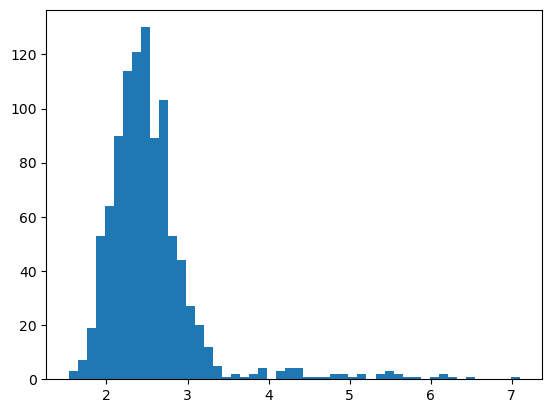

In [16]:
import matplotlib.pyplot as plt

# Flatten the array into 1D
forces_flat = f.flatten()

# Create a histogram
plt.hist(forces_flat, bins=50)

# Show the plot
plt.show()

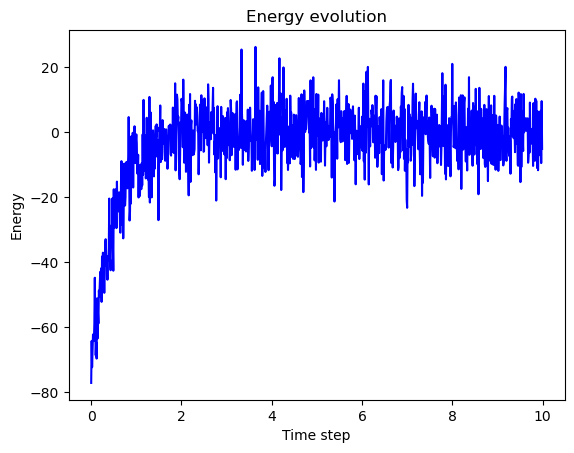

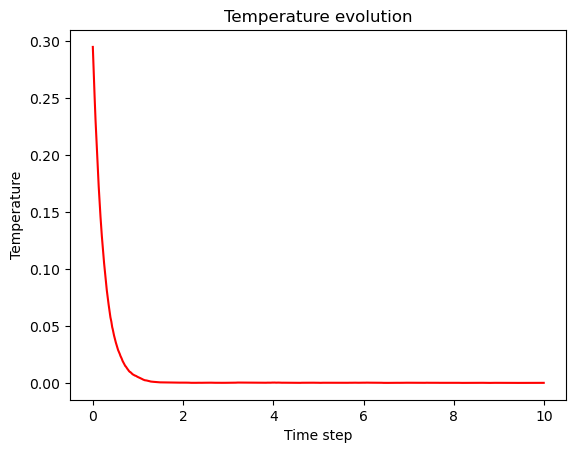

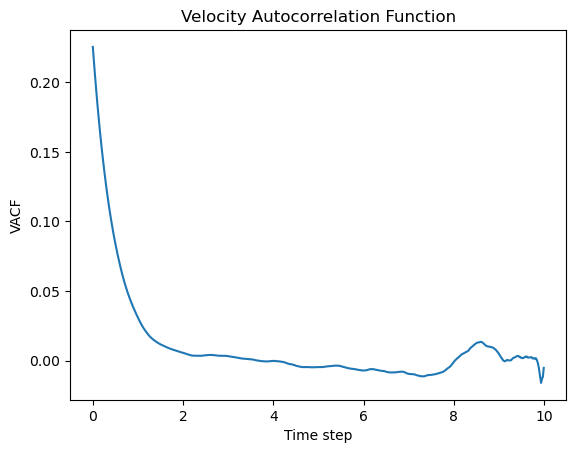

In [17]:
"""plots the energy evolution"""
plt.plot(time_, energy, color='blue', label='Energy')
plt.xlabel('Time step')
plt.ylabel('Energy')
plt.title('Energy evolution')
plt.show()

"""plots the temperature evolution"""
plt.plot(time_, temp, color='red')
plt.xlabel('Time step')
plt.ylabel('Temperature')
plt.title('Temperature evolution')
plt.show()

# Plot the VACF
plt.plot(time_,VACF)
plt.xlabel('Time step')
plt.ylabel('VACF')
plt.title('Velocity Autocorrelation Function')
plt.show()

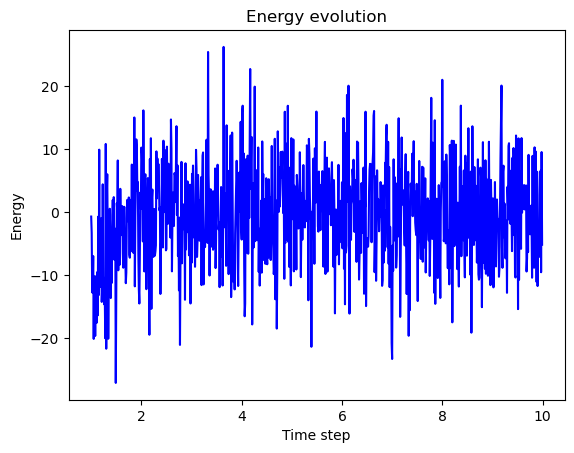

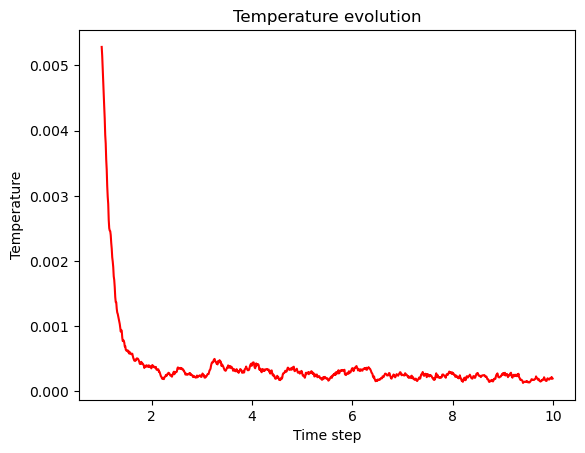

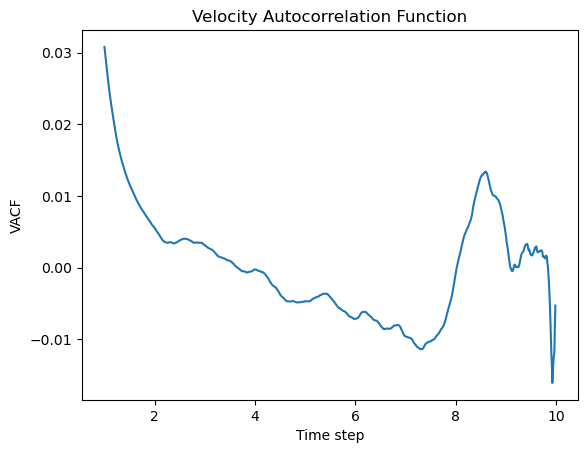

In [18]:
"""plots the energy evolution"""
plt.plot(time_[100:], energy[100:], color='blue', label='Energy')
plt.xlabel('Time step')
plt.ylabel('Energy')
plt.title('Energy evolution')
plt.show()

"""plots the temperature evolution"""
plt.plot(time_[100:], temp[100:], color='red')
plt.xlabel('Time step')
plt.ylabel('Temperature')
plt.title('Temperature evolution')
plt.show()

# Plot the VACF
plt.plot(time_[100:],VACF[100:])
plt.xlabel('Time step')
plt.ylabel('VACF')
plt.title('Velocity Autocorrelation Function')
plt.show()